In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

/home/admin/miniconda3/envs/snowflakes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import os.path
import sys
import re
import itertools
import csv
import datetime
import pickle
from collections import defaultdict, Counter
import random
import gc

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import gensim
from sklearn.metrics import f1_score, classification_report, confusion_matrix, log_loss, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, ShuffleSplit

import local_settings
from local_settings import cnf_model_stoxic_01_CV_f1 as cnf

In [4]:
targetdir = local_settings.data_dir
file_train = os.path.join(targetdir, 'train.csv')
file_test = os.path.join(targetdir, 'test.csv')
file_submission = os.path.join(targetdir, '../submission.csv')

pd_train = pd.read_csv(file_train)
print(pd_train.shape)
pd_test = pd.read_csv(file_test)
print(pd_test.shape)
pd_train.head()

(159571, 8)
(153164, 2)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
X_train_input_word = np.load(os.path.join(local_settings.model_stoxic_data_tfidf_dir, 'X_train_input_word.npy'))
print(X_train_input_word.shape)
X_train_input_wgt = np.load(os.path.join(local_settings.model_stoxic_data_tfidf_dir, 'X_train_input_wgt.npy'))
print(X_train_input_wgt.shape)
X_train = {'input_word': X_train_input_word, 'input_wgt': X_train_input_wgt}

x_test_input_word = np.load(os.path.join(local_settings.model_stoxic_data_tfidf_dir, 'x_test_input_word.npy'))
x_test_input_wgt = np.load(os.path.join(local_settings.model_stoxic_data_tfidf_dir, 'x_test_input_wgt.npy'))
x_test = {'input_word': x_test_input_word, 'input_wgt': x_test_input_wgt}

Y_train = np.load(os.path.join(local_settings.model_stoxic_data_dir, 'Y_train_stoxic.npy'))
print(Y_train.shape)
print(Y_train.sum())
num_word = np.load(os.path.join(local_settings.model_stoxic_data_dir, 'num_word.npy'))
print(num_word)

(159571, 50)
(159571, 50)
(159571,)
1595
[394787]


In [6]:
from make_model import make_model1, MyKerasClassifier
from keras import backend as K

class Classifier(MyKerasClassifier):
    
    def predict(self, x, **kwargs):
        '''
        if y exists
            threshold = average(y)
        else:
            argmax
        '''
        prob = self.predict_proba(x, **kwargs)
        if 'y' in kwargs:
            y = kwargs['y']
            pred = (prob[:,1] > (y.sum() / y.shape[0])).astype(np.int32)
        else:
            pred = np.argmax(prob, 1)
        return self.classes_[pred]
    
    def score(self, x, y):
        '''
        f1_score
        '''
        pred = self.predict(x, y=y)
        score = f1_score(y, pred)
        return score
    
    def score_roc(self, x, y):
        '''
        ROC AUC
        '''
        prob = self.predict_proba(x)
        score = roc_auc_score(y, prob[:,1])
        return score


def make_model(max_sequence_length=20, num_word=10,
               kernel_sizes=[3],
               pooling_sizes=[None],
               num_features=8, gamma=0.0):
    K.clear_session()
    models = make_model1(max_sequence_length=max_sequence_length, num_word=num_word,
                         kernel_sizes=kernel_sizes, pooling_sizes=pooling_sizes,
                         num_features=num_features, gamma=gamma)
    model = models['model']
    return model

In [7]:
WORD_SEQ_NUM = 50
num_features = 64
cnn_kernel_sizes = [3]
cnn_pooling_sizes = [None]

from sklearn.model_selection import validation_curve
#from lib.sk.model_selection import validation_curve_seq
param_range = np.logspace(-9, 0, 10)
param_range

array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00])

In [8]:
ss = ShuffleSplit(n_splits=3, test_size=0.4, random_state=0)

In [9]:
# from multiprocessing import Process, Queue

# def fn(classifier, v, x_train, y_train, x_cv, y_cv, q):
#     classifier.set_params(gamma=v)
#     classifier.fit(x_train, y_train)
#     score_train = {}
#     score_train['f1'] = classifier.score(x_train, y_train)
#     score_train['roc'] = classifier.score_roc(x_train, y_train)
#     score_cv = {}
#     score_cv['f1'] = classifier.score(x_cv, y_cv)
#     score_cv['roc'] = classifier.score_roc(x_cv, y_cv)
#     q.put([score_train, score_cv])

# def loop():
#     now0 = datetime.datetime.now()
#     print(now0)

#     q = Queue()
#     out_f1 = []
#     out_roc = []
#     for train, cv in ss.split(X_train_input_wgt, Y_train):
#         for v in param_range:
#             x_train = {
#                 'input_word': X_train_input_word[train],
#                 'input_wgt': X_train_input_wgt[train],
#             }
#             x_cv = {
#                 'input_word': X_train_input_word[cv],
#                 'input_wgt': X_train_input_wgt[cv],
#             }
#             y_train = Y_train[train]
#             y_cv = Y_train[cv]
#             p = Process(target=fn, args=(classifier, v, x_train, y_train, x_cv, y_cv, q))
#             p.start()
#             out0 = q.get()
#             p.join()
#             out_f1.append([out0[0]['f1'], out0[1]['f1']])
#             out_roc.append([out0[0]['roc'], out0[1]['roc']])

#     print(datetime.datetime.now())
#     print(datetime.datetime.now() - now0)
#     return (out_f1, out_roc)

In [10]:
def fn(classifier, v, x_train, y_train, x_cv, y_cv):
    classifier.set_params(gamma=v)
    classifier.fit(x_train, y_train)
    score_train = {}
    score_train['f1'] = classifier.score(x_train, y_train)
    score_train['roc'] = classifier.score_roc(x_train, y_train)
    score_cv = {}
    score_cv['f1'] = classifier.score(x_cv, y_cv)
    score_cv['roc'] = classifier.score_roc(x_cv, y_cv)
    return [score_train, score_cv]

def loop():
    now0 = datetime.datetime.now()
    print(now0)

    out_f1 = []
    out_roc = []
    for train, cv in ss.split(X_train_input_wgt, Y_train):
        for v in param_range:
            x_train = {
                'input_word': X_train_input_word[train],
                'input_wgt': X_train_input_wgt[train],
            }
            x_cv = {
                'input_word': X_train_input_word[cv],
                'input_wgt': X_train_input_wgt[cv],
            }
            y_train = Y_train[train]
            y_cv = Y_train[cv]
            out0 = fn(classifier, v, x_train, y_train, x_cv, y_cv)
            out_f1.append([out0[0]['f1'], out0[1]['f1']])
            out_roc.append([out0[0]['roc'], out0[1]['roc']])

    print(datetime.datetime.now())
    print(datetime.datetime.now() - now0)
    return (out_f1, out_roc)

## num_features=8

In [11]:
classifier = Classifier(make_model, epochs=5, verbose=1, 
                        max_sequence_length=WORD_SEQ_NUM,
                        kernel_sizes=cnn_kernel_sizes, pooling_sizes=cnn_pooling_sizes,
                        num_word=num_word[0],
                        num_features=8)

In [12]:
x_train = {
    'input_word': X_train_input_word,
    'input_wgt': X_train_input_wgt,
}
y_train = Y_train
classifier.fit(x_train, y_train)

Epoch 1/5
159571/159571 [==============================] - 97s 606us/step - loss: 0.0347 - acc: 0.9900
Epoch 2/5
159571/159571 [==============================] - 96s 602us/step - loss: 0.0196 - acc: 0.9917
Epoch 3/5
159571/159571 [==============================] - 96s 601us/step - loss: 0.0140 - acc: 0.9942
Epoch 4/5
159571/159571 [==============================] - 96s 603us/step - loss: 0.0098 - acc: 0.9959
Epoch 5/5
159571/159571 [==============================] - 96s 602us/step - loss: 0.0069 - acc: 0.9972


In [13]:
classifier.predict_proba(x_train)

array([[1.0000000e+00, 4.4691580e-15],
       [1.0000000e+00, 5.8369980e-09],
       [1.0000000e+00, 7.9831194e-12],
       ...,
       [1.0000000e+00, 9.8155286e-12],
       [1.0000000e+00, 4.4315133e-26],
       [1.0000000e+00, 6.8366612e-13]], dtype=float32)

In [14]:
classifier = Classifier(make_model, epochs=5, verbose=1, 
                        max_sequence_length=WORD_SEQ_NUM,
                        kernel_sizes=cnn_kernel_sizes, pooling_sizes=cnn_pooling_sizes,
                        num_word=num_word[0],
                        num_features=8)

out_f1, out_roc = loop()

2019-03-30 10:33:00.957129
Epoch 1/5
95742/95742 [==============================] - 78s 817us/step - loss: 0.0398 - acc: 0.9900
Epoch 2/5
95742/95742 [==============================] - 78s 811us/step - loss: 0.0183 - acc: 0.9925
Epoch 3/5
95742/95742 [==============================] - 77s 809us/step - loss: 0.0109 - acc: 0.9954
Epoch 4/5
95742/95742 [==============================] - 78s 810us/step - loss: 0.0069 - acc: 0.9973
Epoch 5/5
95742/95742 [==============================] - 78s 810us/step - loss: 0.0049 - acc: 0.9982
Epoch 1/5
95742/95742 [==============================] - 78s 816us/step - loss: 0.0398 - acc: 0.9903
Epoch 2/5
95742/95742 [==============================] - 78s 810us/step - loss: 0.0183 - acc: 0.9922
Epoch 3/5
95742/95742 [==============================] - 78s 810us/step - loss: 0.0113 - acc: 0.9952
Epoch 4/5
95742/95742 [==============================] - 78s 810us/step - loss: 0.0076 - acc: 0.9969
Epoch 5/5
95742/95742 [==============================] - 78s 810

/home/admin/miniconda3/envs/snowflakes/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 1/5
95742/95742 [==============================] - 78s 818us/step - loss: 13.4896 - acc: 0.9900
Epoch 2/5
95742/95742 [==============================] - 78s 815us/step - loss: 0.0558 - acc: 0.9902
Epoch 3/5
95742/95742 [==============================] - 78s 815us/step - loss: 0.0560 - acc: 0.9902
Epoch 4/5
95742/95742 [==============================] - 78s 814us/step - loss: 0.0570 - acc: 0.9902
Epoch 5/5
95742/95742 [==============================] - 78s 813us/step - loss: 0.0567 - acc: 0.9902
Epoch 1/5
95742/95742 [==============================] - 78s 815us/step - loss: 0.0420 - acc: 0.9895
Epoch 2/5
95742/95742 [==============================] - 77s 808us/step - loss: 0.0193 - acc: 0.9921
Epoch 3/5
95742/95742 [==============================] - 77s 809us/step - loss: 0.0121 - acc: 0.9949
Epoch 4/5
95742/95742 [==============================] - 77s 809us/step - loss: 0.0079 - acc: 0.9967
Epoch 5/5
95742/95742 [==============================] - 77s 809us/step - loss: 0.0058 - a

95742/95742 [==============================] - 78s 814us/step - loss: 0.0330 - acc: 0.9909
Epoch 3/5
95742/95742 [==============================] - 78s 814us/step - loss: 0.0292 - acc: 0.9916
Epoch 4/5
95742/95742 [==============================] - 78s 814us/step - loss: 0.0278 - acc: 0.9922
Epoch 5/5
95742/95742 [==============================] - 78s 813us/step - loss: 0.0259 - acc: 0.9929
Epoch 1/5
95742/95742 [==============================] - 78s 818us/step - loss: 0.0787 - acc: 0.9896
Epoch 2/5
95742/95742 [==============================] - 78s 814us/step - loss: 0.0571 - acc: 0.9900
Epoch 3/5
95742/95742 [==============================] - 78s 813us/step - loss: 0.0566 - acc: 0.9900
Epoch 4/5
95742/95742 [==============================] - 78s 811us/step - loss: 0.0566 - acc: 0.9900
Epoch 5/5
95742/95742 [==============================] - 78s 811us/step - loss: 0.0566 - acc: 0.9900
Epoch 1/5
95742/95742 [==============================] - 78s 820us/step - loss: 0.2003 - acc: 0.9897


[[0.82920354 0.83592111 0.85485307]
 [0.72299383 0.78720884 0.79079326]
 [0.81513702 0.82294676 0.74689441]
 [0.74611399 0.83781513 0.78072683]
 [0.42350282 0.59760479 0.44183908]
 [0.51979922 0.44931136 0.34025191]
 [0.01938373 0.         0.01989576]
 [0.01938373 0.         0.        ]
 [0.         0.02063262 0.01989576]
 [0.01938373 0.02063262 0.        ]]
[[0.17212932 0.22849552 0.21126761]
 [0.1406821  0.12215385 0.15528069]
 [0.29702277 0.2484472  0.19982277]
 [0.29359606 0.31993696 0.30984876]
 [0.24786325 0.27296588 0.24062572]
 [0.34642724 0.27259684 0.24844996]
 [0.02040721 0.         0.01963948]
 [0.02040721 0.01853289 0.        ]
 [0.         0.01853289 0.01963948]
 [0.         0.01853289 0.        ]]


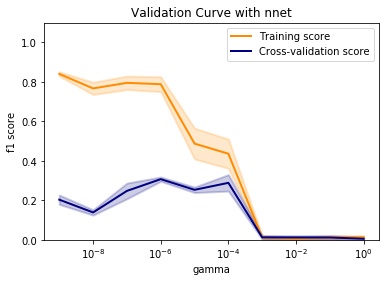

In [15]:
out1 = np.asarray(out_f1)
n_params = len(param_range)
n_cv_folds = out1.shape[0] // n_params
train_scores, test_scores = out1.reshape(n_cv_folds, n_params, 2).transpose((2,1,0))
print(train_scores)
print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_mean
train_scores_std = np.std(train_scores, axis=1)
train_scores_std
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_mean
test_scores_std = np.std(test_scores, axis=1)
test_scores_std

plt.title("Validation Curve with nnet")
plt.xlabel("gamma")
plt.ylabel("f1 score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

[[0.99986067 0.99978913 0.99985395]
 [0.99983575 0.99978497 0.99985846]
 [0.99977408 0.9998213  0.99956475]
 [0.99969279 0.99978141 0.99959631]
 [0.99950986 0.99960961 0.99939411]
 [0.9983259  0.99816718 0.99785927]
 [0.5        0.5        0.5       ]
 [0.5        0.5        0.5       ]
 [0.5        0.5        0.5       ]
 [0.5        0.5        0.5       ]]
[[0.88913688 0.90978933 0.89416232]
 [0.89782255 0.88953232 0.897038  ]
 [0.91950767 0.91579248 0.91754876]
 [0.92946533 0.92886806 0.93279957]
 [0.94338309 0.93984591 0.94884657]
 [0.94088717 0.94092795 0.96861642]
 [0.5        0.5        0.5       ]
 [0.5        0.5        0.5       ]
 [0.5        0.5        0.5       ]
 [0.5        0.5        0.5       ]]


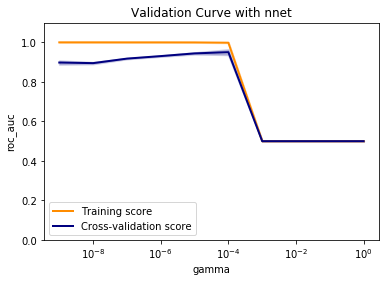

In [16]:
out1 = np.asarray(out_roc)
n_params = len(param_range)
n_cv_folds = out1.shape[0] // n_params
train_scores, test_scores = out1.reshape(n_cv_folds, n_params, 2).transpose((2,1,0))
print(train_scores)
print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_mean
train_scores_std = np.std(train_scores, axis=1)
train_scores_std
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_mean
test_scores_std = np.std(test_scores, axis=1)
test_scores_std

plt.title("Validation Curve with nnet")
plt.xlabel("gamma")
plt.ylabel("roc_auc")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")